# Growth Curves to Predict Area Flooded #
### Paul and Allegra ###

The challenge addressed by this note is how to predict the *final* proportion of a 10km2 grid cell that will be flooded in preparation for flooding. We get a series of proportions $\Pi = p_1,p_2,...,p_i,...,p_n$ and the task is to predict the final proportion, $\hat{p_n}$, given $p_1...p_i$.  Generally there is a tradeoff between $i$ and  $\hat{p_n} - p_n$: The closer $i$ is to $n$, the more accurate $\hat{p_n}$ will be. 

Our general approach is:

1. generate a *library* of growth curves $\Pi(\{\alpha,\beta...\})$ by varying the hyperparameters $\alpha,\beta,...$.  The library contains one curve for each unique combination of hyperparameter values

2. given $i$ observations $p_1,p_2,...,p_i$, find the "best" curve(s) in the library

3. from these curve(s) predict $\hat{p_n}$

We consider statistical and knowledge-based methods. Statistical approaches use models of $\Pi(\{\alpha,\beta...\})$ such as logistic functions and ARIMA models.  Knowledge-based approaches use knowledge and data, such as "the flooding date is determined by weather and by a critical mass of farmers having financing," to simulate the decision to flood. 


## Logistic Model ##

The logistic model says that $p$ grows with $x$ as a logistic function 

\begin{equation}
f_{\lambda,\kappa}(x) = \frac{\lambda}{1+e^{\kappa(x - x_0)}}
\end{equation}

The function has parameters $\lambda$ and $\kappa$ such that the curve grows from 0 to $\lambda$ and its steepness is controlled by $\kappa$. Small values of $\kappa$ produce more linear-like growth, intermediate values produce a characteristic sigmoid shape and large values produce a step function.  

The following code block should be executed but you needn't read it.

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng() # stuff for random sampling

####################  Curve Library ####################

class CurveLibrary ():
    ''' This generates a library of logistic curves given hyperparameters. The basic
    structure works for other kinds of curves as well. For logistic, the parameters are:
        
        -- n the length of the series. n can be anything, but the logistic function 
        rises from 0 to 1 in the range -6 < n < 6.  Extending this range concentrates
        the rise in the middle of the range and not much change is seen elsewhere.
        For our purposes, if we get an observation every 5 days, then the range -6,6
        is equivalent to 13*5 = 65 days, which seems about right. 
        
        -- L the final 'height' of the curve, 0 < L ≤ 1
        
        -- k the steepness with which the curve rises. In theory, k can be
        anything, but if n is in the range -6,6, then k should range from .2 to 2
        
        -- L_ticks, k_ticks are the number of gradations of L and k. 
        
        -- n_curves the number of curves we generate for each L,k combination.  
        The total number of curves is L_ticks * k_ticks * n_curves
        
        -- e * L is the standard deviation of a Gaussian error that we add to each
        point on each curve
        
        -- mc_ticks is used to transform a real-valued curve into a sequence of 
        integers.  Each point on the curve is mapped to np.round(p * mc_ticks)
        
    If e == 0, n_curves should be 1, because all curves for a given L,k combination
    will be identical if e == 0. 
    
    If e > 0 this generates a Markov chain for each curve.
        
        '''
    
    def __init__(self, n, Lmin = .01, Lmax = 1, kmin = .2, kmax = 2, 
                 L_ticks = 30, k_ticks = 30, n_curves = 100, e = .05,
                 mc_ticks = 30):
         
        # equally spaced levels of L and k
        self.n = n
        self.points = np.linspace(-6,6,n)
        self.L_vals = np.linspace(Lmin,Lmax,L_ticks)
        self.k_vals = np.linspace(kmin,kmax,k_ticks)
        
        # indices of L and k 
        self.L_i = np.arange(L_ticks)
        self.k_i = np.arange(k_ticks)
        self.mc_ticks = mc_ticks
        
        # self.lib will be the library of curves for each L,k combination
        self.lib = {L:{k:[] for k in self.k_i} for L in self.L_i}
        
        # self.mc is a library of markov chains for each L,k combination
        self.mc =  {L:{k:[] for k in self.k_i} for L in self.L_i}
        self.n_curves = n_curves
        self.e = e
        
        # Generate the curves
        for L,li in zip(self.L_vals,self.L_i):
            for k,ki in zip(self.k_vals,self.k_i):
                self.lib[li][ki] = self.logistic_curve(L,k)
                
        # generate markov chains
        if self.e > 0: self.mc_for_logistic()
        
        self.x=[]
        
                
    def logistic_curve (self,L,k):
        return np.array([L/(1+np.e**(-k*x)) for x in self.points])
    
    def mc_for_logistic (self):
        ''' 
        If e > 0 then each curve for a given combination of hyperparameters will
        be 'noised up' by adding variates drawn from N(0,e) to each point. This is
        done n_curves times, so each L,k combination gets n_curves noisy curves.
        Each of these curves is mapped to a sequence of m_ticks integers in the 
        range Lmin,Lmax. These integers are a coarse encoding of the curve and 
        are the "symbols" from which we construct a markov chain.  Then we build
        a probability transition matrix for symbols s(i) -> s(i+1). '''
        
        for li in self.L_i:
            for ki in self.k_i:
                # generate n_curves noise vectors; scale e by maximum value of the curve
                std = self.lib[li][ki][-1] * self.e
                noise = rng.normal(0,std,(self.n_curves,self.n))
                curves = noise + self.lib[li][ki]
                
                # can't have values < 0 or > 1
                curves[curves<0]=0
                curves[curves>1]=1
                
                # coarse-code the curves
                curves = np.round(curves*self.mc_ticks).astype(int)
                # make probability transition matrix
                tabl = np.zeros((self.mc_ticks+1,self.mc_ticks+1))
                for c in curves:
                    for p0,p1 in zip(c,c[1:]):
                        tabl[p0,p1]+=1
                
                row_sums = np.sum(tabl, axis=1)
                row_sums[row_sums==0] = .000001
                tabl = tabl / row_sums[:,np.newaxis]
                tabl[tabl == 0] = .0001
                
                self.mc[li][ki] = tabl
        
    
    def get_curve(self, L_index, k_index):
        return self.lib[L_index][k_index]
    
    def final_level (self,curve, m=3):
        ''' returns the mean of the final m points on the curve '''
        return np.round(np.mean(curve[-m:]),4)
    
    def best_n (self, seq, comparison_fn, n):
        ''' returns the n best table curves based on the comparison function. 
        Smaller values for table curves (either RMSE or -log(p)) are better values.
        '''
        best = [[1000000,0,0] for _ in range(n)]
        for L in self.L_i:
            for k in self.k_i:
                result = [comparison_fn(seq,L,k),L,k]
                self.x.append(result[0])
                # if result is better than the worst item in best_k
                if result[0] < best[-1][0]:
                    best.append(result)
                    best = sorted(best,key=lambda x: x[0])[0:n]
        return best
    
    def prob_of_seq (self,seq,Li,ki):
        # returns the log probability of the transitions in seq irrespective
        # of the length of seq
        mc = self.mc[Li][ki]
        s = np.round(seq*self.mc_ticks).astype(int)
        lp = 0
        for p0,p1 in zip(s,s[1:]):
            lp += - np.log(mc[p0,p1])
        return lp
    
    def RMSE (self,seq,Li,ki):
        # returns the RMSE between a table curve and seq. 
        # len(seq) must be <= len table curve.  However, this assumes that the 
        # seq and table curve both 'start at zero'; i.e., one cannot be offset
        # in time from the other.  
        table_curve = self.lib[Li][ki]
        if len(seq) > len(table_curve):
            raise ValueError ("sequence is longer than curves in library")
        else:
            return np.mean((seq - table_curve[:len(seq)])**2)
    
    def max_prob (self,seq,n):
        ''' returns the n_best maximum probability generators (i.e., minimum log prob)'''
        return self.best_n(seq, self.prob_of_seq, n)
    
    
    def minRMSE (self,seq,n):
        ''' returns the n_best maximum probability generators (i.e., minimum log prob)'''
        return self.best_n(seq, self.RMSE, n)
    
    
####################  Plotting functions ####################
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd
import seaborn as sns



def plot_series (y,x=None,label=None,color=None,xlim = None, ylim=None, xlabel= None, ylabel=None,title = None, figsize=(8,6)):
    ''' xlim and ylim must be lists of the form [lower_bound,upper_bound]'''
    fig, ax = plt.subplots(figsize=figsize)
    ax = plt.gca()
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    if x is None:
        ax.plot(np.arange(len(y)), y, label=label,color=color,linewidth=.5)
    else:
        ax.plot(x, y, label=label,color=color,linewidth=.5)
    if title is not None: plt.title(title)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)

def plot_multiseries (df,x=None,standardize=False, xlabel = None, ylabel = None, title = None):
    ''' Be sure that the first column in df is the x index, or specify which column is x '''
    fig, ax = plt.subplots(figsize=(8,6))
    if x is None: x = df.columns[0]
    
    if standardize:
        _df = pd.DataFrame(df[x])
        m = df.mean()
        s = df.std()
        for col in df.columns:
            if not col == x:
                _df['Z_'+col] = (df[col] - m[col])/s[col]
    else:
        _df = df
                   
    for col in _df.columns:
        if not col == x:
            plt.plot(_df[x], _df[col], label='Line '+col,linewidth=1)

    if title is not None : plt.title(title)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)

    #add legend
    plt.legend()

    #display plot
    plt.show() 
    
def plot_scatter (x,y, s=10, c = '0', xlabel = 'X', ylabel = 'Y', title=""):
    plt.scatter(x, y, s, color = c, alpha=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Making a curve library and plotting curves ##

Let's generate a curve library for logistic curves of length 30 for 400 different $\lambda,\kappa$ combinations (i.e., 20 levels of each of $\lambda$ and $\kappa$):

In [2]:
cl = CurveLibrary(n=30)

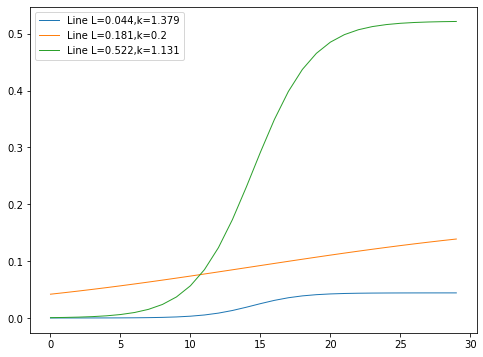

In [3]:
def make_label(l,k):
    return "L="+str(np.round(cl.L_vals[l],3))+",k="+str(np.round(cl.k_vals[k],3))

a = cl.get_curve(1,19)
a_label = make_label(1,19)

b = cl.get_curve(5,0)
b_label = make_label(5,0)

c = cl.get_curve(15,15)
c_label = make_label(15,15)

df = pd.DataFrame(np.array([np.arange(30),a,b,c]).T, columns = ['day',a_label,b_label,c_label])
#df = pd.DataFrame(np.array([np.arange(30),a]).T, columns = ['day',a_label])
plot_multiseries(df)

## Finding the "best" logistic curve -- MSE and MLE ##

We build a library of logistic curves of length $n$ for $\lambda,\kappa$ combinations.  Then, given real data $\pi = p_1,p_2,...,p_i$, we want to find the "best" curve: the one that does the best job of predicting $p_n$.

### MSE ###

One approach is to find the $\lambda,\kappa$ curve that minimizes the mean squared difference between data points  $\pi = p_1,p_2,...,p_i$ and curve points $c = c_1,c_2,...,c_i$.  To illustrate, imagine we have seen 10 data points and we want to find the $\lambda,\kappa$ curve that fits these points best:

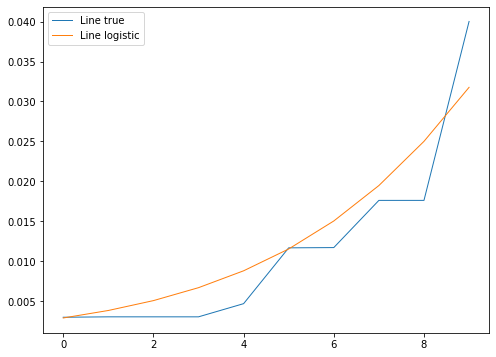

In [4]:
# First ten "readings" for one grid cell in Senegal River Valley
p0 = np.array([0.00295988, 0.00301329, 0.00301329, 0.00301329, 0.00466335,
       0.01165721, 0.01168972, 0.01760135, 0.01760135, 0.040017  ])

# library curve c that has the smallest mean squared difference between c and p
c0 = np.array([0.00287018, 0.00380889, 0.00504513, 0.00666615, 0.00877965,
       0.01151492, 0.01502109, 0.01946064, 0.02499555, 0.03176417])

df = pd.DataFrame(np.array([np.arange(10),p0,c0]).T, columns = ['day','true','logistic'])
plot_multiseries(df)


Now having selected the best-fitting $\lambda,\kappa$ curve we can extrapolate to data we haven't seen.  The following curves show the $\lambda,\kappa$ extending out to day 29 and the actual data extending out to day 29:

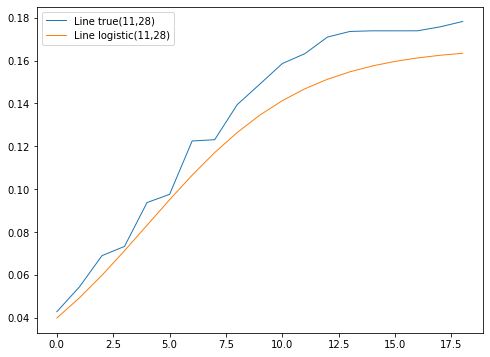

In [5]:
# continuation of the grid cell proportions beyond the tenth data point
p1 = np.array([0.04278528, 0.05434495, 0.06894462, 0.07327006, 0.09374536,
       0.09756568, 0.12248486, 0.12309216, 0.13946845, 0.14901345,
       0.15864554, 0.16325663, 0.17099714, 0.17363304, 0.17392799,
       0.17392799, 0.17393728, 0.17577893, 0.17829407])

# continuation of the best-fitting library curve beyond the tenth data point
c1 = np.array([0.03984885, 0.04923826, 0.05979402, 0.07123585, 0.08315789,
       0.09507994, 0.10652177, 0.11707753, 0.12646693, 0.13455162,
       0.14132024, 0.14685515, 0.1512947 , 0.15480087, 0.15753614,
       0.15964964, 0.16127066, 0.1625069 , 0.16344561])

df = pd.DataFrame(np.array([np.arange(19),p1,c1]).T, columns = ['day','true(11,28)','logistic(11,28)'])
plot_multiseries(df)

So the logistic curve that best fit the first 10 points of true data continues to track the true data after the tenth data point.  In other words, given ten days of data we can predict the remaining 18 days of data.  The result isn't perfect:  In reality the true curve tops out at roughly 17.8% whereas the prediction is 16.3%, but in this case the prediction is pretty good.



### Maximum likelihood ###

Another approach is to define the "best" curve as the one that is most likely to have generated the data we've seen so far.  That is, we want to find $\lambda = l, \kappa = k$ that maximizes $P((l,k) | \pi)$.

We'll start by calculating $P(\pi | (l,k))$.  Then, because we'll be ranking curves to find the "best" one, we can exploit the proportionality $P((l,k) | \pi) \propto P(\pi | (l,k))$.  That is, whichever curve has the highest $P(\pi | (l,k))$ also has the highest $P((l,k) | \pi)$. 

The problem is that curves are series of real values so the probability of any particular curve is zero.  So first we digitize curves so that they are sequences of integers instead of reals.  For example, the true curve when digitized becomes:

```[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5]```

Even after digitizing, the probability of any given curve is zero, but digitizing allows us to approximate the probability of a curve as a product of single-step transition probabilities:

\begin{equation}
P(\pi | \lambda,\kappa) = \prod_{t=1...i} P_{\lambda,\kappa}(\pi_{t},\pi_{t+1})
\end{equation}


where $P_{\lambda,\kappa}(\pi_{t},\pi_{t+1})$ is the probability of a transition between two consecutive values in the real data (e.g., the transition between 0 at t=7 and 1 at t=8) according to a particular $\lambda, \kappa$ model.  Finding these transition probabilities for each $\lambda = l, \kappa = k$ combination is the job of the `mc_for_logistic` function in the `CurveLibrary` class, above. We won't discuss it further here.

Finally, having searched for the $\lambda = l, \kappa = k$ combination that maximizes $P(\pi | \lambda,\kappa)$, we can exploit the proportionality $P((l,k) | \pi) \propto P(\pi | (l,k))$.  By finding the curve that maximizes $P(\pi | \lambda,\kappa)$, we have also found the $\lambda = l, \kappa = k$ combination that is most likely to have generated the real data $\pi$.


## Predicting $p_n$  ## 

We want to predict $p_n$, the final value of a series $\Pi = p_1,p_2,...,p_i,...,p_n$.  For example, we want to predict the proportion of a grid cell that is flooded at the end of a planting period. 

Because our data may be noisy, we will try to predict not a single point but the average of the last three points.  We call this the `final_level` of a series. 

Thanks to Glorie and the Dakar team we have time series data for the proportion of area flooded in each of 52 grid cells in the Senegal River Valley.  In fact, we have data for 2019, 2020 and 2021.  The time series are 28, 30 and 29 points long in 2019, 2020 and 2021, respectively.  Each point in a series is derived from a Sentinel II satellite image. These are gathered every five days, so the 2019 data represents 28 * 5 = 140 days of activity in each grid cell.  

We begin by creating curve libraries for series of the appropriate length.  Note that the *only* thing we know about the data is the length of the series. The methods we have described are *not* data-driven. No machine learning is involved in creating these curve libraries. 

However, we don't know how many observations will happen in a season before the season begins, so whereas for hindcasting we can create curve libraries for exactly the number of observations that were made, for forecasting we must guess at the number of observations that will be made.  For this reason, we will hindcast and forecast from a *single* curve library that is built for sequences of 30 observations.  

In [6]:
cl30 = CurveLibrary(30)

Now we want to assess the accuracy of predictions $\hat{p_n}$, and for this we need real data.  It will be called **g** in honor of Glorie!

But th bad news is that there are two Glorie datasets, the original one and another dated March 22.  We suspect that the March 22 dataset is errorful in some unknown ways, so the following analyses are done with the original dataset. 

In [7]:
def day_of_year (timestamp):
    return timestamp.timetuple().tm_yday  # returns 1 for January 1st

g = pd.read_csv("/home/hubert/Desktop/Heuristics/RS/glorie-extract_flooding_events/data_in_use/Glorie New/flooding_dates.csv", parse_dates = ['date'])
g['year'] = g.date.dt.year
g['month'] = g.date.dt.month
g['day'] = g.date.dt.day
g['DOY'] = g.date.apply(day_of_year)

# Whether total_area is accurate is under discussion; similarly for what it should be called. 
g['flooded'] = g.aoi_area * g.p


g2019 = g[g.year == 2019].sort_values(['ID','DOY'])
g2020 = g[g.year == 2020].sort_values(['ID','DOY'])
g2021 = g[g.year == 2021].sort_values(['ID','DOY'])
g2022 = g[g.year == 2022].sort_values(['ID','DOY'])

data2019 = {}
data2020 = {}
data2021 = {}
data2022 = {}


for data, frame in zip([g2019,g2020,g2021,g2022],[data2019,data2020,data2021,data2022]):
    for id in g.ID.unique():
        curve = data[data.ID == id]
        frame[id] = curve[['ID','Latitude','Longitude','month','day','DOY','aoi_area','p','flooded']]
        

# Writing out the data 
# g2019.to_csv("/Users/prcohen/Pitt/Code/Habitus/growth_curves/g2019.csv")
# g2020.to_csv("/Users/prcohen/Pitt/Code/Habitus/growth_curves/g2020.csv")
# g2021.to_csv("/Users/prcohen/Pitt/Code/Habitus/growth_curves/g2021.csv")
# g2022.to_csv("/Users/prcohen/Pitt/Code/Habitus/growth_curves/g2022.csv")

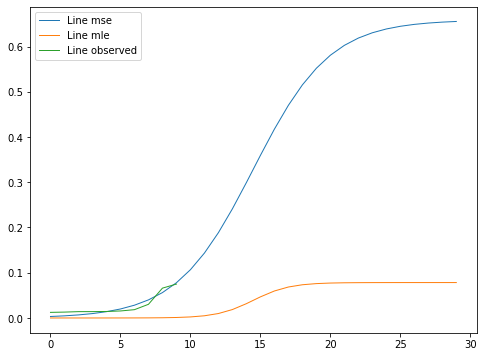

[[array([0.00328248, 0.00471941, 0.00677886, 0.00972365, 0.01392035,
         0.01987286, 0.02825918, 0.03996309, 0.05608306, 0.07788675,
         0.10666654, 0.14345379, 0.18859324, 0.24128392, 0.29932109,
         0.3592996 , 0.41733677, 0.47002745, 0.5151669 , 0.55195415,
         0.58073394, 0.60253763, 0.6186576 , 0.63036151, 0.63874783,
         0.64470034, 0.64889704, 0.65184183, 0.65390128, 0.65533821])],
 [array([1.01289159e-06, 2.20122233e-06, 4.78362490e-06, 1.03952160e-05,
         2.25877717e-05, 4.90720180e-05, 1.06566853e-04, 2.31225933e-04,
         5.00773719e-04, 1.08019332e-03, 2.31011655e-03, 4.85241979e-03,
         9.83049164e-03, 1.86203969e-02, 3.16369515e-02, 4.66389105e-02,
         5.96554652e-02, 6.84453704e-02, 7.34234423e-02, 7.59657455e-02,
         7.71956688e-02, 7.77750883e-02, 7.80446361e-02, 7.81692952e-02,
         7.82267901e-02, 7.82532743e-02, 7.82654669e-02, 7.82710784e-02,
         7.82736608e-02, 7.82748492e-02])]]

In [8]:
def predict_pn (seq, library, n_obs = None, plot = False, best_n = 5, average = False):
    ''' Given a sequence of n_obs consecutive observations from one grid cell, this
    finds the best_n best matching curves in library. If the sequence is longer than
    n_obs observations, this uses just the first n_obs observations. '''
    
    # for plotting purposes we need a sequence of length library.n in which the
    # first elements are from seq
    
    padded = np.full(library.n, np.nan)
    
    
    if n_obs is None:
        observed = seq
        padded[:len(seq)] = seq[:] 
    elif type(n_obs) == int and n_obs <= len(seq):
        observed = seq[:n_obs]
        padded[:n_obs] = seq[:n_obs]
    else:
        raise ValueError("If not None, n_obs cannot exceed the length of seq")
    
    best_mse = library.minRMSE(observed,best_n)
    best_mle = library.max_prob(observed,best_n)
    mse_curves = [library.get_curve(best_mse[i][1],best_mse[i][2]) for i in range(best_n)]
    mle_curves = [library.get_curve(best_mle[i][1],best_mle[i][2]) for i in range(best_n)]
    
    if average is True:
        mse_curves = [np.mean(np.array(mse_curves), axis=0)]
        mle_curves = [np.mean(np.array(mle_curves), axis=0)]
        print(mle_curves)
    
    # plot the best (i.e., the zeroth) of the best_n curves or the average if averaging
    if plot:
        df = pd.DataFrame(
            np.stack([np.arange(library.n),mse_curves[0], mle_curves[0], padded]).T,
            columns = ['day','mse','mle','observed'])
        plot_multiseries(df)
            
    return [mse_curves,mle_curves]


## To illustrate: Pick one grid cell from the 2021 data:
grid_cell = list(data2019.values())[9]
series = np.array(grid_cell.p)

## Suppose we see the first 15 data points:
predict_pn(series,cl30,n_obs = 10,plot=True,average=False,best_n=1)

In this example, the actual value of $p_n$ is roughly 0.3.  But the predictions are made after observing just 10 points.  Based on these, the MSE method predicts $p_n = 0.65$ while the MLE method predicts $p_n = 0.078$. (These are the final values in the predicted curves that are printed as arrays of numbers, above). You can see why the MSE method was misled:  The curve it picked is a very close match to the first ten points of data (the green line).

Observing a couple more data points improves the predictions a bit. Now the MLE method thinks the final value of the data will be 0.3855 but the MSE method is still wildly off: it thinks the final value of the data will be 0.9965. 

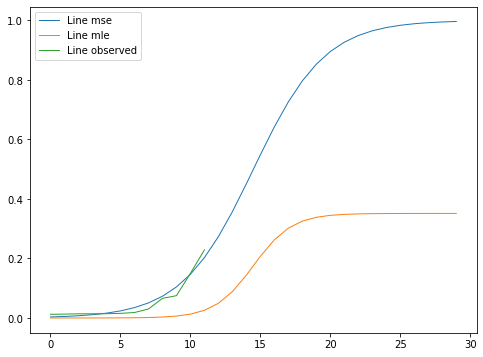

[[array([0.00343956, 0.00507671, 0.00748724, 0.01102966, 0.01622071,
         0.0237961 , 0.03478426, 0.05058343, 0.07301582, 0.10430345,
         0.14687376, 0.20288317, 0.27340643, 0.35745102, 0.45128464,
         0.54871536, 0.64254898, 0.72659357, 0.79711683, 0.85312624,
         0.89569655, 0.92698418, 0.94941657, 0.96521574, 0.9762039 ,
         0.98377929, 0.98897034, 0.99251276, 0.99492329, 0.99656044])],
 [array([9.57589971e-06, 1.97681460e-05, 4.08073961e-05, 8.42333648e-05,
         1.73849039e-04, 3.58709261e-04, 7.39724287e-04, 1.52369042e-03,
         3.13109133e-03, 6.40316720e-03, 1.29673270e-02, 2.57582396e-02,
         4.93270084e-02, 8.85937484e-02, 1.44196407e-01, 2.07182903e-01,
         2.62785562e-01, 3.02052302e-01, 3.25621071e-01, 3.38411983e-01,
         3.44976143e-01, 3.48248219e-01, 3.49855620e-01, 3.50639586e-01,
         3.51020601e-01, 3.51205461e-01, 3.51295077e-01, 3.51338503e-01,
         3.51359542e-01, 3.51369734e-01])]]

In [9]:
predict_pn(series,cl30,n_obs = 12,plot=True,average=False,best_n=1)

### IGNORE THIS:  Dealing with leading small numbers ###

One notable attribute of Glorie's data is that the first few data points generally are very close to zero; for example, the first eight values of the series in the previous figure are :

```
0.0014, 0.0094, 0.0094, 0.0094, 0.0127, 0.0137, 0.0147, 0.0166
```
This means that the first 40 days of the planting season show almost no flooding activity (remember: Sentinel II images arrive every five days).

The function `predict_pn` has a parameter `left_n` that allows us to clip off the first `left_n` values of a series, padding out the series on its right end.  The following code block clips the first eight values of the series in the previous example. This seems to help bring both the mean squared error method and the maximum likelihood method closer to the true final level of 0.1265, with predictions of 0.2428 and 0.1492, respectively.

We haven't done an extensive evaluation of whether this helps and this method is *not* used in the following evaluations.  

In [10]:
# grid_cell = list(data2021.values())[15]
# series = np.array(grid_cell.p)
# predict_pn(series,12,cl_2021,left_n = 8,plot=True)

## Accuracy of Predictions of true_p ##

With this introduction we can now look at the accuracy of these methods for all grid cells, for all three years.

We will evaluate predictions of `true_p`, the final value(s) in each series of Glorie's data.  We will also translate `true_p` to hectares so we can express accuracy in terms of hectares.  

We will compare our methods for predicting `true_p` with predictions based on the previous year's data.

Finally, we will evaluate how the accuracy of our predictions depends on the number of processed Sentinel II observations that we have prior to prediction. 

### Date ranges for 2019, 2020 and 2021 data ###

The date ranges of processed Sentinel II data for the three years of data are:

- 2019:  January 13 - May 28
- 2020:  January 3 - May 27
- 2021:  January 7 - May 27

Note that recording started a week to 10 days later in 2019. 

For the first part of this evaluation, we will base our evaluations on 14 observations.  For the three years, these are the day and date of the last observation:

- 2019:  Day 78, March 19
- 2020:  Day 68, March 8
- 2021:  Day 72, March 13

The following code block defines a function to compute accuracy for a single grid cell and another function to compute accuracy for all grid cells.

We strongly encourage you to read the doc string for `accuracy`.  The function is defined in such a way that you can ask for the accuracy of a prediction of a value that occurs midway through the season.  For example, even though you expect 30 observations in the season, you might only have seen 15 observations.  You can of course predict the value of the 30th observation given the first 15, but you can also hindcast to get the accuracy of the prediction of the 15th observation given the first 10 observations.  

In [11]:
def accuracy (data, library, n_obs, to_predict = -1):
    '''
    The goal is to predict future values of a series given the first n_obs values.
    Thus, data[:n_obs] will be used to obtain predictions of data[n_obs:] .  
    
    In general, the length of the series  will be library.n.  Conversely, the
    curve library that we use for predictions is created for an expected length
    of the series.  For example, we expect to get 30 observations of flooding
    level during a planting season, so library.n = len(data) = 30, and n_obs < 30. 
    
    An interesting case is where n_obs < len(data) < library.n.  This case arises
    when we're in the middle of a season and we want to know how well earlier 
    observations predicted not the end of the season but the current observation.
    For example, suppose len(data) = 20, meaning we've made 20 observations, and 
    we want to ask retrospectively about our accuracy predicting the 20th 
    observation given the first 15 observations.  
    
    The to_predict argument is a negative integer that specifies how many values at
    the end of `data` we want to predict.  For example, if len(data) = 20 and
    n_obs = 15 and to_predict = -1, this means we want the accuracy of predictions
    of the last value in `data` given the first 15 observations, and we can do this
    as soon as we've observed the 20th datum even if the number of observations 
    will eventually be 30. 
    
    If to_predict = -m, then the value we're trying to predict is the mean of
    the final m values in the data. 
    '''
    
    n = len(data)
    
    if n < n_obs:
        raise ValueError("Number of observations to use cannot exceed the length of the data")
    
    if n > library.n:
        raise ValueError(f"Library curves are of length {library.n} but data is of length {len(data)}")
    
    # Get the single best library curve for MSE and for MLE.  
    # Alternatively, consider averaging multiple library curves, e.g., 
    # predict_pn(data,n_obs,library,best_n = 3, average=True)
    mse_curves, mle_curves = predict_pn(data,library,n_obs,best_n = 1)
    
    # These curves are of length library.n, but the data may be shorter than that.
    # So if the data is if length n, we want to calculate the accuracy of the 
    # to_predict values going backward from the nth point in the curves
    
    mse_sub_curve = mse_curves[0][:n]
    mle_sub_curve = mle_curves[0][:n]
    
    mse_prediction = np.mean(mse_sub_curve[to_predict:])
    mle_prediction = np.mean(mle_sub_curve[to_predict:])
    true_val = np.mean(data[to_predict:])
    
    return (mse_prediction, mle_prediction, true_val)


def accuracy_over_grid_cells (year, data, library, n_obs, to_predict = -1):
    ''' This computes accuracy over all grid cells, translates proportions to hectares,
    and produces a dataframe for visualization and further analysis. '''

    
    df=pd.DataFrame(columns=[
        'year', 'ID', 'lat', 'lon', 
        'true_p', 'mse_p', 'mle_p', 'true_ha', 'mse_ha', 'mle_ha', 
        'mse_p_diff', 'mle_p_diff', 'mse_ha_diff', 'mle_ha_diff'
        ])
        
    for ID, grid_cell in data.items():
        _ID = int(ID)
        lat = grid_cell.Latitude.iloc[0]
        lon = grid_cell.Longitude.iloc[0]
        aoi_area = grid_cell.aoi_area.iloc[0]
        series = np.array(grid_cell.p)
        
        # We will assess the accuracy of the final three values at the end of
        # te planting season, but keep in mind that we can also assess the 
        # accuracy of predictions of any point during the season.  See the 
        # documentation of the `accuracy` function
        
        mse_p, mle_p, true_p = accuracy(series, library, n_obs, to_predict = -3)
        mse_ha, mle_ha, true_ha  = mse_p * aoi_area, mle_p * aoi_area, true_p * aoi_area
        
        # negative numbers mean we're underestimating true values, positive means overestimating
        mse_p_diff, mle_p_diff  = (mse_p - true_p), (mle_p - true_p)
        mse_ha_diff, mle_ha_diff  = (mse_ha - true_ha), (mle_ha - true_ha)
        
        df.loc[len(df.index)] = [
            year, _ID, lat, lon, true_p, mse_p, mle_p, true_ha, mse_ha, mle_ha, 
            mse_p_diff, mle_p_diff, mse_ha_diff, mle_ha_diff
        ]
    return df


In [12]:
n_obs = 15
acc2019 = accuracy_over_grid_cells(2019, data2019, cl30, n_obs)
acc2020 = accuracy_over_grid_cells(2020, data2020, cl30, n_obs)
acc2021 = accuracy_over_grid_cells(2021, data2021, cl30, n_obs)

In [13]:
acc2019.true_p

0     0.139229
1     0.086354
2     0.412322
3     0.150426
4     0.008345
5     0.009802
6     0.012069
7     0.120728
8     0.193345
9     0.296893
10    0.314762
11    0.375964
12    0.235826
13    0.047982
14    0.019894
15    0.194270
16    0.107723
17    0.159975
18    0.288393
19    0.141291
20    0.314699
21    0.518668
22    0.118489
23    0.414213
24    0.226461
25    0.262608
26    0.077013
27    0.221486
28    0.304615
29    0.060245
30    0.373537
31    0.517681
32    0.083005
33    0.038895
34    0.363910
35    0.036107
36    0.336840
37    0.260801
38    0.158343
39    0.498085
40    0.000133
41    0.405531
42    0.012205
43    0.161607
44    0.337499
45    0.047399
46    0.082509
47    0.051490
48    0.171595
49    0.143117
50    0.422639
51    0.332120
Name: true_p, dtype: float64

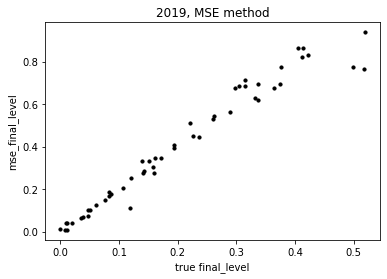

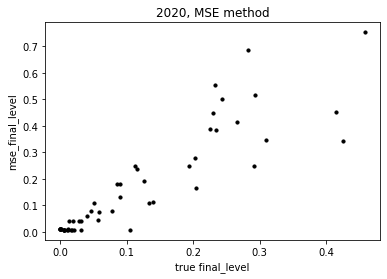

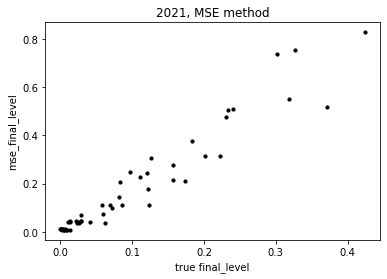

In [14]:
plot_scatter(acc2019.true_p,acc2019.mse_p, xlabel = 'true final_level', ylabel = 'mse_final_level', title = "2019, MSE method")
plot_scatter(acc2020.true_p,acc2020.mse_p, xlabel = 'true final_level', ylabel = 'mse_final_level', title = "2020, MSE method")
plot_scatter(acc2021.true_p,acc2021.mse_p, xlabel = 'true final_level', ylabel = 'mse_final_level', title = "2021, MSE method")

The MSE method does not work well. Even in 2019, when the linear relationship between true final_level and predicted final_level is fairly tight, the slope is wrong. On average the predicted final_level is roughly double what it should be. 

Here are the results for the maximum likelihood method:

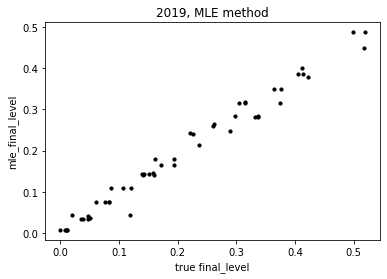

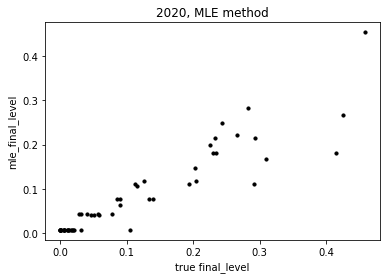

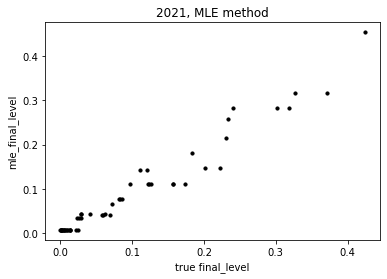

In [15]:
plot_scatter(acc2019.true_p, acc2019.mle_p, xlabel = 'true final_level', ylabel = 'mle_final_level', title = "2019, MLE method")
plot_scatter(acc2020.true_p, acc2020.mle_p, xlabel = 'true final_level', ylabel = 'mle_final_level', title = "2020, MLE method")
plot_scatter(acc2021.true_p, acc2021.mle_p, xlabel = 'true final_level', ylabel = 'mle_final_level', title = "2021, MLE method")

These results are better.  The slope is approximately 1.0 in each year.  Let's calculate the root mean squared error between the predicted and true final levels:

### RMSE for actual and predicted final_level ###


In [16]:
for year,results in zip([2019,2020,2021],[acc2019,acc2020,acc2021]):
    rmse_mse = np.mean((results.mse_p - results.true_p)**2)**.5
    rmse_mle = np.mean((results.mle_p - results.true_p)**2)**.5
    print(f"Year {year}: RMSE for mse method: {rmse_mse:.4f} and mle method: {rmse_mle:.4f}")

Year 2019: RMSE for mse method: 0.2423 and mle method: 0.0259
Year 2020: RMSE for mse method: 0.1147 and mle method: 0.0597
Year 2021: RMSE for mse method: 0.1402 and mle method: 0.0241


On average, the difference between actual and predicted final levels is 21% in 2019 and 12% in 2020 and 2021 for the our mean-squared error method, and is 3% - 6% for the maximum likelihood method.  

### Using last year's data to predict next year's final_level ###

It's hard to say whether these are good or bad RMSE numbers without a standard of comparison.  As a standard we will use 2019 *data* to predict 2020 data, and do the same for 2020 and 2021.  First we'll present scatterplots and then RMSE figures.

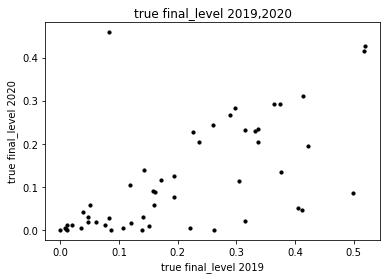

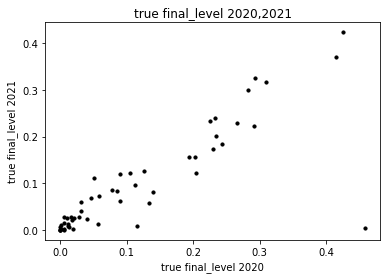

In [17]:
plot_scatter(acc2019.true_p,acc2020.true_p, xlabel = 'true final_level 2019', ylabel = 'true final_level 2020', title = "true final_level 2019,2020")
plot_scatter(acc2020.true_p,acc2021.true_p, xlabel = 'true final_level 2020', ylabel = 'true final_level 2021', title = "true final_level 2020,2021")

While 2020 data does a pretty good job of predicting 2021 data, the same isn't true of 2019 and 2020.  Here are the RMSE numbers:

In [18]:
rmse2019 = np.mean((acc2019.true_p - acc2020.true_p)**2)**.5
rmse2020 = np.mean((acc2020.true_p - acc2021.true_p)**2)**.5
print(f"RMSE when 2019 final level is used to predict 2020 final level:  {rmse2019:.4f}")
print(f"RMSE when 2020 final level is used to predict 2021 final level:  {rmse2020:.4f}")

RMSE when 2019 final level is used to predict 2020 final level:  0.1483
RMSE when 2020 final level is used to predict 2021 final level:  0.0714


This is pretty bad, which is pretty encouraging!  The average errors incurred when using one year's final level to predict the next are comparable to those of our prediction methods, *however, our prediction methods only saw 15 data points from each year*! And our maximum likelihood method error is roughly 1/3rd of that of using historical data in 2020 and a bit more than half that of historical data in 2021. 

In short, if we use the maximum likelihood method with only 15 data points from each year, our error is better than that of using last year's data.

###  Accuracy of predictions of area flooded in hectares ###

So while it's important to know how well we can predict the final_level of the *proportion* of an area that will be flooded, some areas are very small and some are much larger.  Each 10km x 10km grid cell has the same area -- 10,000 hectares -- but not every grid cell is entirely within our study area.  In fact, the distribution of "arable area" in the 52 grid cells looks like this (it's the same for 2019, 2020, 2021):

minimum arable: 150.9200, maximum arable 8611.8400


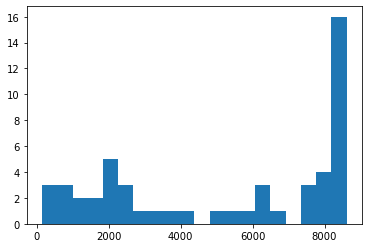

In [19]:
aoi_area_by_gridcell = [v.aoi_area.iloc[0] for v in data2019.values()]
plt.hist(aoi_area_by_gridcell,bins=20)
print(f"minimum arable: {min(aoi_area_by_gridcell):.4f}, maximum arable {max(aoi_area_by_gridcell):.4f}")


Moreover, some grid cells see a lot of flooding, some almost none.  The histograms of hectares flooded in 52 grid cells in each of the three years are: 

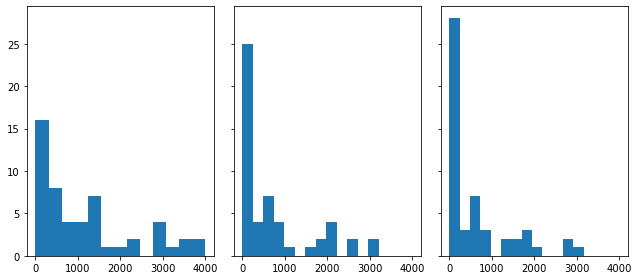

In [20]:
fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, tight_layout=True,figsize = (9,4))

for data,i in zip([data2019,data2020,data2021],[0,1,2]):
    final_flooded = [v.flooded.max() for v in data.values()]
    axs[i].hist(final_flooded, bins=13)
    
plt.show()

So while it's important to know how well we can predict the final_level of the proportion of an area that's flooded, some of these areas are very small and some are much larger.  Thus, we will repeat our previous analyses but instead of predicting the proportion of an area, we'll predict the area itself.  

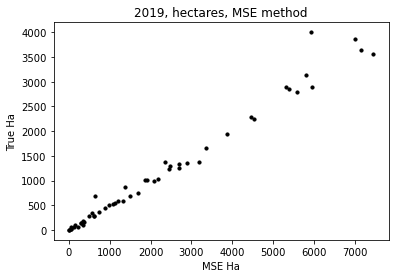

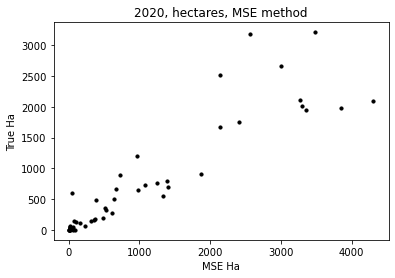

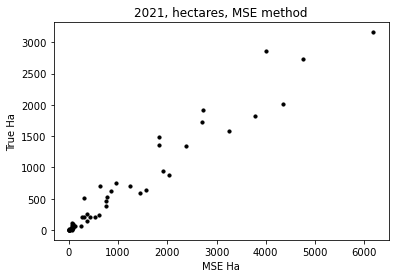

In [21]:
plot_scatter(acc2019.mse_ha, acc2019.true_ha, xlabel = 'MSE Ha', ylabel = 'True Ha', title = "2019, hectares, MSE method")
plot_scatter(acc2020.mse_ha, acc2020.true_ha, xlabel = 'MSE Ha', ylabel = 'True Ha', title = "2020, hectares, MSE method")
plot_scatter(acc2021.mse_ha, acc2021.true_ha, xlabel = 'MSE Ha', ylabel = 'True Ha', title = "2021, hectares, MSE method")

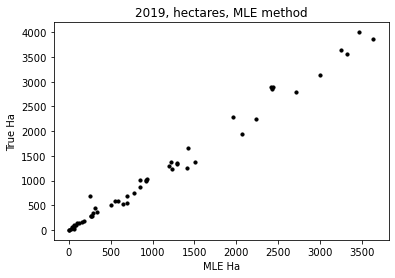

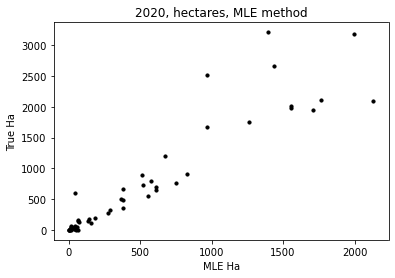

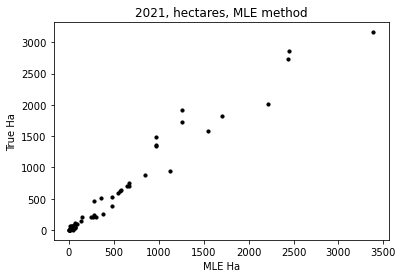

In [22]:
plot_scatter(acc2019.mle_ha, acc2019.true_ha, xlabel = 'MLE Ha', ylabel = 'True Ha', title = "2019, hectares, MLE method")
plot_scatter(acc2020.mle_ha, acc2020.true_ha, xlabel = 'MLE Ha', ylabel = 'True Ha', title = "2020, hectares, MLE method")
plot_scatter(acc2021.mle_ha, acc2021.true_ha, xlabel = 'MLE Ha', ylabel = 'True Ha', title = "2021, hectares, MLE method")

### RMSE for Hectares ###

How far off are our projections of flooded hectares?  The following calculates the root mean squared error between projections and true values for three years and our two methods:



In [23]:
for year,results in zip([2019,2020,2021],[acc2019,acc2020,acc2021]):
    rmse_mse = np.mean((results.mse_ha - results.true_ha)**2)**.5
    rmse_mle = np.mean((results.mle_ha - results.true_ha)**2)**.5
    print(f"Year {year}: RMSE for mse method: {rmse_mse:.4f} and mle method: {rmse_mle:.4f}")

Year 2019: RMSE for mse method: 1491.8235 and mle method: 184.2261
Year 2020: RMSE for mse method: 595.8440 and mle method: 457.5064
Year 2021: RMSE for mse method: 815.8913 and mle method: 183.9096


So using our maximum likelihood method, the average error measured in hectares, over grid cells varies from roughly 200 hectares to 450 hectares.  Is this good? We will simply sum our errors and compare the sum with the final reading of area flooded. Note that errors can be positive or negative, depending on whether we over- or under-estimate the final area flooded.  But this is fine if our task is to predict the final area flooded for the entire region of 52 grid cells.  Our predictions will too high in some cases and too low in others.  

One way to express this error is as a fraction of the total number of hectares, summed over all grid cells, that are recorded as flooded: 

In [24]:
for year,results in zip([2019,2020,2021],[acc2019,acc2020,acc2021]):
    total_mse = np.sum(results.mse_ha)
    total_mle = np.sum(results.mle_ha)
    print(year)
    print(f"total from mse method: {total_mse:.0f}, total flooded (ha): {np.sum(results.true_ha):.0f}, ratio: {total_mse/np.sum(results.true_ha):.4f}  ")
    print(f"total from mle method: {total_mle:.0f}, total flooded (ha): {np.sum(results.true_ha):.0f}, ratio: {total_mle/np.sum(results.true_ha):.4f}\n")

2019
total from mse method: 115744, total flooded (ha): 59864, ratio: 1.9334  
total from mle method: 55374, total flooded (ha): 59864, ratio: 0.9250

2020
total from mse method: 50780, total flooded (ha): 36961, ratio: 1.3739  
total from mle method: 25774, total flooded (ha): 36961, ratio: 0.6973

2021
total from mse method: 55233, total flooded (ha): 31936, ratio: 1.7295  
total from mle method: 28946, total flooded (ha): 31936, ratio: 0.9064



So while our mean squared error method clearly overestimates the total area that will eventually be flooded, the maximum likelihood method is remarkably accurate in 2019 and 2021, less so in 2020.  But compared with SAED estimates of area planted, which can be off by a factor of two, the maximum likelihood estimates are very accurate. 



### Plotting results on a map and analysis of errors ###

This section analyzes the sources of errors with particular attention to *where* our predictions are wrong.  Errors and other data are presented on maps using the following code.

In [25]:
# Read in shapes
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
lower = gpd.read_file('/Users/prcohen/Pitt/Code/Habitus/growth_curves/SRV_LowerDelta.kml', driver = 'KML')
upper = gpd.read_file('/Users/prcohen/Pitt/Code/Habitus/growth_curves/SRV_UpperDelta_Extended.kml', driver = 'KML')
lower['color'] = 'lightblue'
upper['color'] = 'lightblue'
both = gpd.GeoDataFrame(pd.concat([lower, upper]))
both = both.to_crs({'init': 'epsg:4326'}) # "Both" is the shapes for the Upper and Lower Delta.


def plot_map(data, varstring, filename=None, title=None, cmap='RdYlBu',vmin=None,vmax=None):
#     Plot the background shape:

    fig, ax0 = plt.subplots(figsize=(0.01,0.01))
    # Note: I don't know why you get a blank plot first (I made it tiny). 
    #       For a notebook you can define fig, ax0 one time and then comment it out the next run.
    ax = both.plot(color = both['color'], edgecolor = 'black', linewidth = 0.5, alpha=0.25, figsize = (7,7))
    
    # for scales that have positive and negative range, try cmap = 'RdYlBu'
    # for ascending scales try a color such as cmap = 'Greens'or cmap = 'YlOrRd'
    points = plt.scatter(data['lon'], data['lat'], c = data[varstring], 
                         vmin = vmin, vmax = vmax,
                         cmap = cmap, s = 100, edgecolor = 'black', linewidths = 0.1)
    fig.colorbar(points, ax = ax, fraction=0.03, pad=0.04)
    #plt.show()
    plt.title(title)
    #plt.savefig(filename)



DriverError: /Users/prcohen/Pitt/Code/Habitus/growth_curves/SRV_LowerDelta.kml: No such file or directory

First we'll look at the "true" hectares by grid cell.  Note that we are discussing with Sibiry and Glorie whether these numbers are correct.  The current definition of `true_ha` is `final_level * total_area`, where `final_level` is the mean of the last three values of `p`, which is itself a proportion.  We assume it is the proportion of the `total_area` but this needs to be confirmed.  

In the following map, the darkest points are in the north, close to the river, which makes sense.  Very light points are generally on the border of the area of interest.  This also makes sense: the total_area for these grid cells is small because only a fraction of the grid cell may fall within the area of interest. 

These results are for 2019.  To see results for 2020 and 2021 just select acc2020 or acc2021.

In [ ]:
plot_map(acc2019,'true_ha',title='actual hectares, 2019',cmap='YlOrRd')

Now let's look at where our predictions were most wrong.  Not surprisingly, our biggest errors are in the grid cells that have the highest 'true hectares'.  In 2019, we badly underestimate the flooded area in one grid cell in the north-central part of the map (the dark red point) and overestimate in a grid cell in the north-west area (the light blue point). 

In 2020, we mostly underestimate 'true hectares', again in the north-central area. In 2021 there's a mix of underestimation and overestimation throughout the map, but few grid cells are badly mis-estimated.

In [ ]:
plot_map(acc2019,'mle_ha_diff',title='true hectares minus predicted hectares, 2019',cmap='RdYlBu',vmin = -1200, vmax=1200)
plot_map(acc2020,'mle_ha_diff',title='true hectares minus predicted hectares, 2020',cmap='RdYlBu',vmin = -1200, vmax=1200)
plot_map(acc2021,'mle_ha_diff',title='true hectares minus predicted hectares, 2021',cmap='RdYlBu',vmin = -1200, vmax=1200)

## The benefits of additional observations ##

The previous analyses are based on observing 14 data points in each of three years, corresponding to observations that occur between early January and mid-March.  What if we shortened or lengthened the observation period?  We can't shorten it by much because very little flooding happens in January and early February, but we will analyze the accuracy of our predictions given 10,12,14,16 and 18 observations.

The lower and upper dates of observation windows are:

- 2019: February 27 - April 8
- 2020: February 17 - March 28
- 2021: February 21 - April 1

In [ ]:
# I changed formats, I need to fix the following

# def accuracy_by_obs (year, data, library, obs):

#     accuracies = []
#     # RMSE between predicted and actual hectares based on mean squared error method
#     rmse_ha_mse = []
#     # RMSE between predicted and actual hectares based on maximum likelihood method
#     rmse_ha_mle = []

#     for num_observations in obs:
#         acc = accuracy(year, data, num_observations, library)
#         accuracies.append(acc)
#         rmse_ha_mse.append(np.mean((acc.mse_ha - acc.true_ha)**2)**.5)
#         rmse_ha_mle.append(np.mean((acc.mle_ha - acc.true_ha)**2)**.5)
        
#         total_mse = np.sum(acc.mse_ha)
#         total_mle = np.sum(acc.mle_ha)
#         print(f"{year} observations {num_observations}: total from mse method: {total_mse:.0f}, total flooded (ha): {np.sum(acc.true_ha):.0f}, ratio: {total_mse/np.sum(acc.true_ha):.4f}  ")
#         print(f"{year} observations {num_observations}: total from mle method: {total_mle:.0f}, total flooded (ha): {np.sum(acc.true_ha):.0f}, ratio: {total_mle/np.sum(acc.true_ha):.4f}\n")
        
#     plot_series(x = obs, y= rmse_ha_mse, 
#                 title=str(year)+': RMSE in hectares mean squared error method',
#                 figsize=(6,4),xlabel = 'num. observations',ylabel='RSME (ha)')
    
#     plot_series(x = obs, y= rmse_ha_mle, 
#                 title=str(year)+': RMSE in hectares max_likelihood method',
#                 figsize=(6,4),xlabel = 'num. observations',ylabel='RSME (ha)')
    
    
# accuracy_by_obs(2019,data2019,cl30,[10,12,14,16,18])
# accuracy_by_obs(2020,data2020,cl30,[10,12,14,16,18])
# accuracy_by_obs(2021,data2021,cl30,[10,12,14,16,18])